In [1]:
# Import modules
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels as sm
from statsmodels.tsa.api import VAR

# Add custom module location to PATH
import os, sys
lib_path = os.path.abspath(os.path.join('..', 'py'))
sys.path.append(lib_path)

# Load custom modules
import weather as we
import rescue_events as re

In [2]:
# Define paths
events_file_path = "./../event_data/Sündmused_2011-2015_Marek.xlsx"
cached_events_file_path = "./../Cache/events.csv"
events = re.load(events_file_path, cached_events_file_path)

Loading Data
Data Loaded!
110478 events loaded
9814 rows have missing datetime - removing



In [55]:
start_date = events.Aeg.min().date()
end_date   = events.Aeg.max().date()
days  = pd.date_range(start=start_date, end=end_date,  freq='D')
events["date"] = events.Aeg.map(pd.Timestamp.date).astype("datetime64[ns]")
daily_count = pd.DataFrame(events[["Aeg","date"]].groupby(["date"]).count()["Aeg"].loc[days].fillna(0).astype("int16"))
daily_count_by_type = events.pivot_table(
    index="date", 
    columns="Väljakutse liik SOS",
    values="Aeg",
    aggfunc="count",
    fill_value=0
).loc[days].fillna(0).astype("int16")

### Paljude väljakutsetega päevad

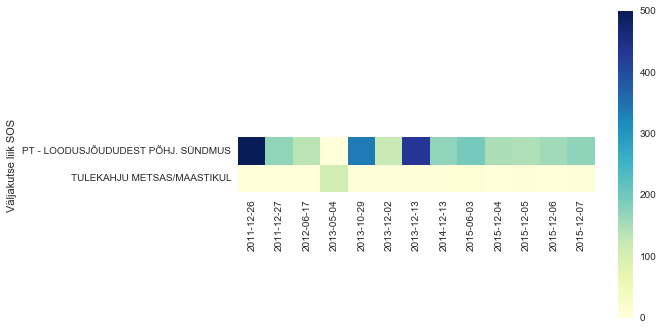

In [5]:
treshold = 100
frequent = daily_count_by_type.loc[(daily_count_by_type>treshold).any(axis=1), (daily_count_by_type>treshold).any(axis=0)]
sns.heatmap(frequent.transpose(), xticklabels=frequent.index.date, square=True , cmap="YlGnBu");

In [6]:
cache_path = "../Cache/"
stations_path = "../weather data/stations_estonia.csv"
stations = we.load_stations(path=stations_path)   
weather = we.load_estonian_weather(cache_path, stations, [2015,2014,2013,2012,2011])

*** Loading weather ***
Cache '../Cache/2015_estonia.csv.gz' exists, skipping filtering...
* Loading year: 2015 *
* Loading year complete! *
Cache '../Cache/2014_estonia.csv.gz' exists, skipping filtering...
* Loading year: 2014 *
* Loading year complete! *
Cache '../Cache/2013_estonia.csv.gz' exists, skipping filtering...
* Loading year: 2013 *
* Loading year complete! *
Cache '../Cache/2012_estonia.csv.gz' exists, skipping filtering...
* Loading year: 2012 *
* Loading year complete! *
Cache '../Cache/2011_estonia.csv.gz' exists, skipping filtering...
* Loading year: 2011 *
* Loading year complete! *
*** Loading weather complete ***


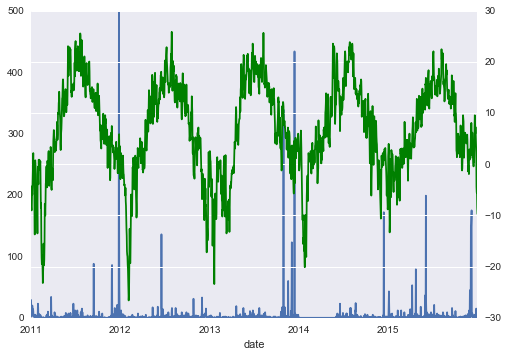

In [7]:
event_loodus = daily_count_by_type["PT - LOODUSJÕUDUDEST PÕHJ. SÜNDMUS"]
weather_avg_temp = (weather[weather.station=="EN000026242"].pivot(index='date', columns='type')["value"]["TAVG"]/10)

event_loodus.plot()
weather_avg_temp.plot(secondary_y=True, style='g')

input_data = pd.concat([event_loodus, weather_avg_temp], axis=1)

In [8]:
model = VAR(input_data)
print(model.select_order(15))
results = model.fit(5)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         10.58        10.58    3.930e+04        10.58
1         7.762        7.780        2350.        7.769
2         7.742        7.772        2303.        7.753
3         7.703       7.745*        2214.        7.718
4         7.696        7.750        2199.        7.716
5        7.691*        7.757       2188.*       7.715*
6         7.693        7.772        2193.        7.722
7         7.695        7.786        2197.        7.729
8         7.699        7.802        2206.        7.737
9         7.703        7.819        2215.        7.746
10        7.707        7.835        2224.        7.754
11        7.707        7.846        2223.        7.758
12        7.711        7.863        2232.        7.767
13        7.712        7.876        2236.        7.773
14        7.713        7.889        2237.        7.778
15        

In [9]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, May, 2016
Time:                     22:12:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    7.75399
Nobs:                     1821.00    HQIC:                   7.71200
Log likelihood:          -12145.2    FPE:                    2180.82
AIC:                      7.68746    Det(Omega_mle):         2154.71
--------------------------------------------------------------------
Results for equation PT - LOODUSJÕUDUDEST PÕHJ. SÜNDMUS
                                           coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------------------
const                                         2.597203         0.625624            4.151           0.000
L1.PT - LOODUSJÕUDUDEST PÕHJ. SÜNDMUS   

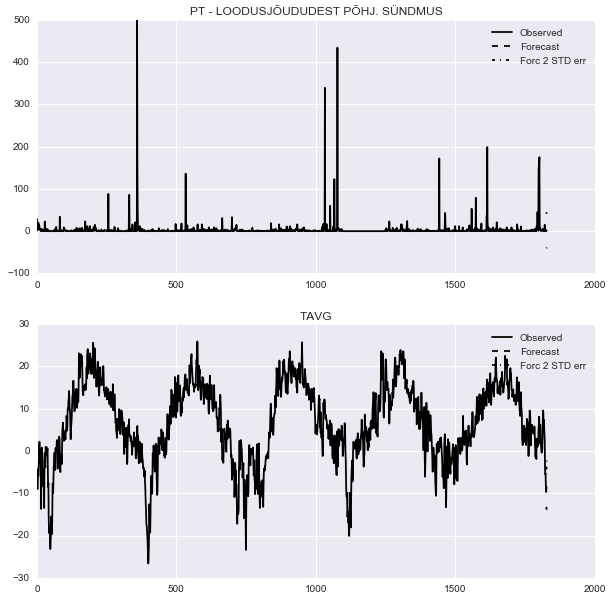

In [10]:
results.plot_forecast(2)

# ARIMA

## First attempt: endog:events, exog:temp

In [11]:
input_data2 = input_data.astype("float64")

c:\users\markl\appdata\local\programs\python\python35\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                       ARIMA Model Results                                       
Dep. Variable:     D2.PT - LOODUSJÕUDUDEST PÕHJ. SÜNDMUS   No. Observations:                 1824
Model:                                    ARIMA(5, 2, 5)   Log Likelihood               -8134.393
Method:                                          css-mle   S.D. of innovations             20.820
Date:                                   Mon, 23 May 2016   AIC                          16294.786
Time:                                           22:14:09   BIC                          16366.400
Sample:                                       01-03-2011   HQIC                         16321.204
                                            - 12-31-2015                                         
                                                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------

c:\users\markl\appdata\local\programs\python\python35\lib\site-packages\statsmodels\tsa\arima_model.py:1847: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


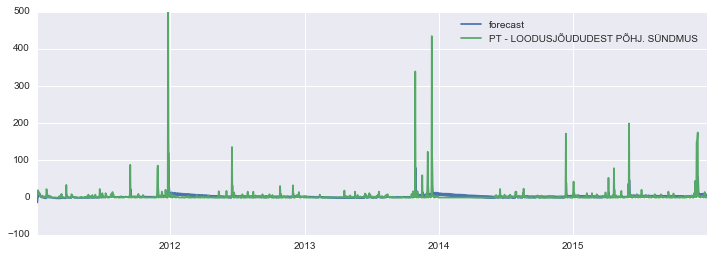

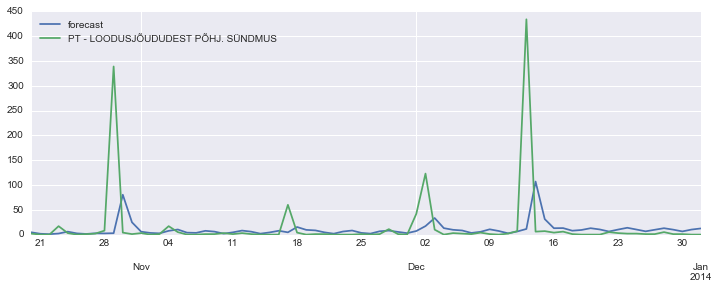

In [13]:
from statsmodels.tsa.api import ARIMA

exog = input_data2["TAVG"]
ARIMA_results = ARIMA(input_data2["PT - LOODUSJÕUDUDEST PÕHJ. SÜNDMUS"], (5,2,5),exog=exog).fit()
print(ARIMA_results.summary())
fig, ax = plt.subplots(figsize=(12, 4))
ARIMA_results.plot_predict(ax=ax);

fig, ax = plt.subplots(figsize=(12, 4))
ARIMA_results.plot_predict(
    start="2013-10-20",
    end="2014-01-01",
    ax=ax
);

The model reacts to the number of events but is unable to predict the future, instead it just lags behind. This is somewhat epected, as the model only uses the number of past events and current temperature.

## Second attempt - Using Temperature lags in exog

To improve the results gotten from the previous attempt, I will add lagged temperature values as an exogenous variables.

c:\users\markl\appdata\local\programs\python\python35\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                      ARIMA Model Results                                       
Dep. Variable:     D.PT - LOODUSJÕUDUDEST PÕHJ. SÜNDMUS   No. Observations:                 1825
Model:                                   ARIMA(1, 1, 1)   Log Likelihood               -8118.954
Method:                                         css-mle   S.D. of innovations             20.653
Date:                                  Mon, 23 May 2016   AIC                          16255.908
Time:                                          22:14:19   BIC                          16305.492
Sample:                                      01-02-2011   HQIC                         16274.198
                                           - 12-31-2015                                         
                                                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------------
co

c:\users\markl\appdata\local\programs\python\python35\lib\site-packages\statsmodels\tsa\arima_model.py:1847: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


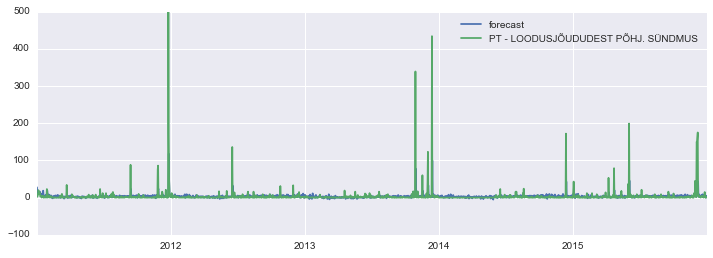

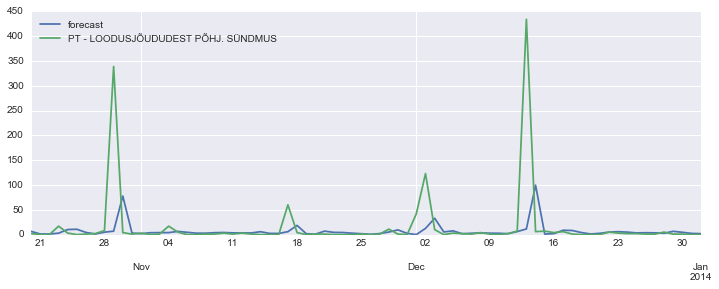

In [14]:
from statsmodels.tsa.tsatools import lagmat
exog = lagmat(input_data2["TAVG"], 5)

ARIMA_results = ARIMA(input_data2["PT - LOODUSJÕUDUDEST PÕHJ. SÜNDMUS"], (1,1,1),exog=exog).fit()
print(ARIMA_results.summary())
fig, ax = plt.subplots(figsize=(12, 4))
ARIMA_results.plot_predict(ax=ax);

fig, ax = plt.subplots(figsize=(12, 4))
ARIMA_results.plot_predict(
    start="2013-10-20",
    end="2014-01-01",
    ax=ax
);


### Third attempt:
#### Clean lagged data from zeroes & increase number of lags

c:\users\markl\appdata\local\programs\python\python35\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                       ARIMA Model Results                                       
Dep. Variable:     D2.PT - LOODUSJÕUDUDEST PÕHJ. SÜNDMUS   No. Observations:                 1804
Model:                                    ARIMA(5, 2, 5)   Log Likelihood               -8076.425
Method:                                          css-mle   S.D. of innovations             21.224
Date:                                   Mon, 23 May 2016   AIC                          16216.850
Time:                                           22:23:16   BIC                          16392.778
Sample:                                       01-23-2011   HQIC                         16281.785
                                            - 12-31-2015                                         
                                                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------

c:\users\markl\appdata\local\programs\python\python35\lib\site-packages\statsmodels\tsa\arima_model.py:1847: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


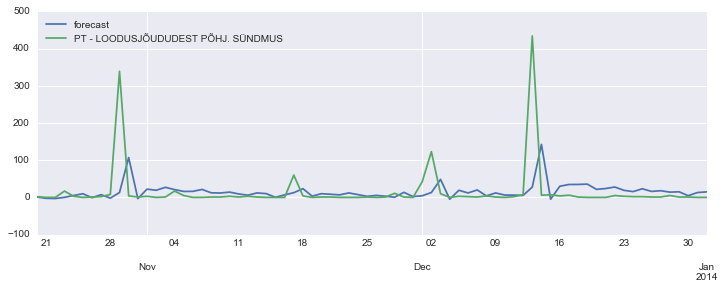

In [25]:
from statsmodels.tsa.tsatools import lagmat

lags = 20
order = (5,2,5)
endog = input_data2["PT - LOODUSJÕUDUDEST PÕHJ. SÜNDMUS"]
exog = lagmat(input_data2["TAVG"], lags)

#Remove zeroes
endog = endog[lags:]
exog = exog[lags:]

ARIMA_results = ARIMA(endog, order ,exog).fit()

print(ARIMA_results.summary())
fig, ax = plt.subplots(figsize=(12, 4))
ARIMA_results.plot_predict(
    start="2013-10-20",
    end="2014-01-01",
    ax=ax
);

### Fourth attempt:
#### Try to predict forest fires instead

In [27]:
daily_count_by_type.columns

Index(['DEM - LÕHKEKEHA', 'DEM - POMMIOHT', 'DEM- POMMIÄHVARDUS',
       'DEM-LÕHKEKEHA', 'DEMINEERIMISE SÜNDMUS', 'INFOSÜNDMUS',
       'INFRA - ELEKTRIVÕRKUDE AVARII', 'INFRA - GAASIAVARII',
       'INFRA - KOMMUNAALAVARII', 'INFRA-ELEKTRIVÕRKUDE AVARII',
       'INFRA-GAASIAVARII', 'INFRASTRUKTUURIDE AVARII', 'Muud', 'PLAHVATUS',
       'PT - ABI OSUTAMINE', 'PT - ABITUS SEISUNDIS INIMENE',
       'PT - ABITUS SEISUNDIS LOOM/LIND', 'PT - LOODUSJÕUDUDEST PÕHJ. SÜNDMUS',
       'PT - SÜGAVUSEST JA KÕRGUSEST PÄÄSTMINE', 'PT - VARING', 'PÄÄSTETÖÖD',
       'REOSTUMINE', 'REOSTUMINE - BIOLOOGILINE', 'REOSTUMINE - GAASILINE',
       'REOSTUMINE - KEEMILINE', 'REOSTUMINE - NAFTASAADUSTEGA',
       'REOSTUMINE - RADIOAKTIIVNE', 'TK OHT', 'TR - LENNUÕNNETUS',
       'TR - LIIKLUSÕNNETUS', 'TR - RAUDTEEÕNNETUS', 'TRANSPORDIAVARII',
       'TULEKAHJU', 'TULEKAHJU HOONES', 'TULEKAHJU METSAS/MAASTIKUL',
       'TULEKAHJU TRANSPORDIVAHENDIS', 'TULEKAHJU VÄLJASPOOL HOONEID',
       'TULETÕRJE ALAR

In [32]:
daily_count_by_type["TULEKAHJU METSAS/MAASTIKUL"].describe()

count    1826.000000
mean        3.300657
std         9.441150
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max       111.000000
Name: TULEKAHJU METSAS/MAASTIKUL, dtype: float64

In [36]:
daily_count_by_type["TULEKAHJU METSAS/MAASTIKUL"].astype("float64").describe()

count    1826.000000
mean        3.300657
std         9.441150
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max       111.000000
Name: TULEKAHJU METSAS/MAASTIKUL, dtype: float64

c:\users\markl\appdata\local\programs\python\python35\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                   ARIMA Model Results                                   
Dep. Variable:     D2.TULEKAHJU METSAS/MAASTIKUL   No. Observations:                 1804
Model:                            ARIMA(5, 2, 5)   Log Likelihood               -5648.481
Method:                                  css-mle   S.D. of innovations              5.533
Date:                           Mon, 23 May 2016   AIC                          11360.962
Time:                                   22:48:11   BIC                          11536.891
Sample:                               01-23-2011   HQIC                         11425.897
                                    - 12-31-2015                                         
                                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------
const                                   0.0007      0.002      0.361    

c:\users\markl\appdata\local\programs\python\python35\lib\site-packages\statsmodels\tsa\arima_model.py:1847: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


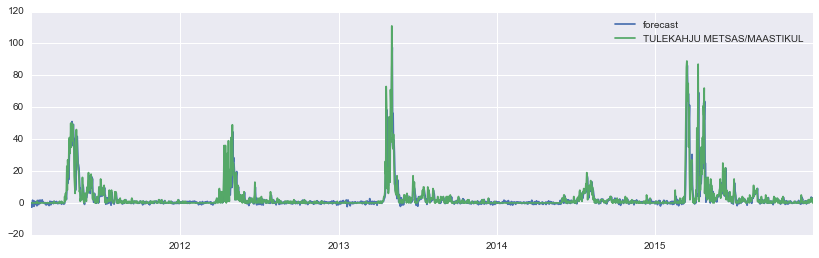

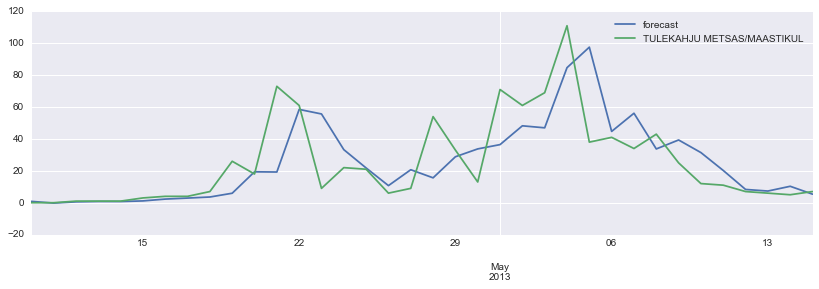

In [40]:
from statsmodels.tsa.tsatools import lagmat

lags = 20
order = (5,2,5)
endog = daily_count_by_type["TULEKAHJU METSAS/MAASTIKUL"].astype("float64")
exog = lagmat(input_data2["TAVG"], lags)

#Remove zeroes
endog = endog[lags:]
exog = exog[lags:]

ARIMA_results = ARIMA(endog, order ,exog).fit()

print(ARIMA_results.summary())

fig, ax = plt.subplots(figsize=(14, 4))
ARIMA_results.plot_predict(ax=ax);

fig, ax = plt.subplots(figsize=(14, 4))
ARIMA_results.plot_predict(
    start="2013-04-10",
    end="2013-05-15",
    ax=ax
);

### Fift attempt:
#### Using only first part of the data (that does not have discontinuities) for training

c:\users\markl\appdata\local\programs\python\python35\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                   ARIMA Model Results                                   
Dep. Variable:     D2.TULEKAHJU METSAS/MAASTIKUL   No. Observations:                  978
Model:                            ARIMA(5, 2, 5)   Log Likelihood               -3049.271
Method:                                  css-mle   S.D. of innovations              5.452
Date:                           Mon, 23 May 2016   AIC                           6162.542
Time:                                   23:06:33   BIC                           6318.878
Sample:                               01-23-2011   HQIC                          6222.025
                                    - 09-26-2013                                         
                                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------
const                                   0.0007      0.002      0.357    

c:\users\markl\appdata\local\programs\python\python35\lib\site-packages\statsmodels\tsa\arima_model.py:1847: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


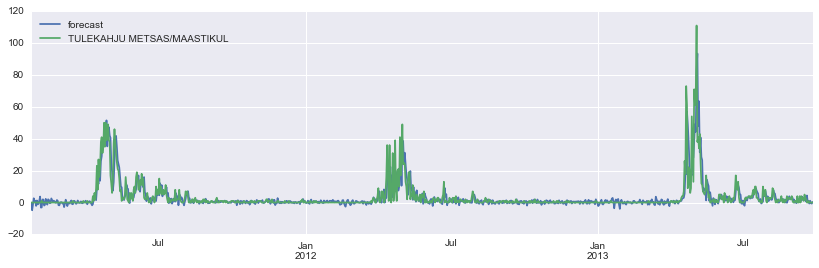

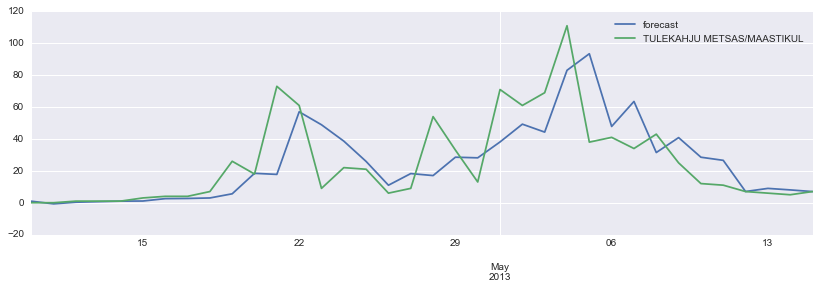

In [54]:
lags = 20
order = (5,2,5)
endog = daily_count_by_type["TULEKAHJU METSAS/MAASTIKUL"].astype("float64")
exog = lagmat(input_data2["TAVG"], lags)

limit = 1000
#Remove zeroes
endog = endog[lags:limit]
exog = exog[lags:limit]

ARIMA_results = ARIMA(endog, order ,exog).fit()

print(ARIMA_results.summary())

fig, ax = plt.subplots(figsize=(14, 4))
ARIMA_results.plot_predict(ax=ax);

fig, ax = plt.subplots(figsize=(14, 4))
ARIMA_results.plot_predict(
    start="2013-04-10",
    end="2013-05-15",
    ax=ax
);

# Conclusion

The attempts to use Vector autoregression (VAR) and Autoregressive integrated moving average (ARIMA) to predict occurrence of rescue events failed.